In [254]:
import os 
import re
import pandas as pd
import numpy as np
from collections import Counter

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from gensim.models.phrases import Phrases, Phraser
from nltk import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

### 1. Extract all text from html files to dataframes

In [255]:
sessions = [110,111,112,113,114,115,116,117,118,119]
text_dict = {}

for session in sessions:

    df_rows = []
    
    bills_path = f"../data/congress_api_data_10_21/{session}/text"

    for file in os.listdir(bills_path):

        match = re.search(r'(\d+)[^\da-zA-Z]*([A-Za-z]+)[^\da-zA-Z]*(\d+)', file, re.IGNORECASE)
        if match:
            result = f"{match.group(1)}-{match.group(2).lower()}{match.group(3)}"
            bill_id = result 
        else:
            bill_id = ""

        file_path = os.path.join(bills_path, file)

        with open(file_path) as file:
            soup = BeautifulSoup(file, 'html.parser')

            df_rows.append({
                "bill_id": bill_id,
                "original_text": soup.get_text(separator=" ", strip=True).replace("\n"," ")
            })

    df = pd.DataFrame(df_rows)
    text_dict[session] = df
    

In [256]:
all_text_df = pd.concat(text_dict).reset_index().drop(columns=['level_1']).rename(columns={'level_0':'congress'})

all_text_df.head()

,congress,bill_id,original_text
0,110,110-hr1752,[Congressional Bills 110th Congress] [From the...
1,110,110-hr1999,[Congressional Bills 110th Congress] [From the...
2,110,110-s1386,[Congressional Bills 110th Congress] [From the...
3,110,110-hr1227,[Congressional Bills 110th Congress] [From the...
4,110,110-hr1515,[Congressional Bills 110th Congress] [From the...


In [257]:
all_text_df.shape

(1657, 3)

### 2. Clean & Tokenize

#### Cleaning/Tokenize Functions

In [258]:
def clean_text(text):
    """
    simple cleaning of legislation text: 
        - removes preamble & non-alphabet characters
        - normalizes whitespace
        - standardizes casing
    """

    # remove all text before either "A BILL" or "AN ACT" - this removes all the preamble
    match = re.search(r"^(.*?)(?=(A BILL|AN ACT))", text, flags = re.DOTALL)
    if match:
        text = text[match.end():]

    # keep only letters no other characters
    text = re.sub(r"[^A-Za-z]+", " ", text)
    # Normalize whitespace
    text = re.sub(r"\s+", " ", text)

    # lowercase
    text = text.lower() 

    return text

####################################################################################################

def process_tokens(text, stop_words, string=False):
    """
    simple tokenization of cleaned legislative text
        - tokenizes
        - removes stopwords
        - lemmatizes using ntlk WordNetLemmatizer
    
    text: text to tokenize (str)
    stop_words: stop words to remove (set/list)
    string: if True, return tokens as a single string. Otherewise, return as list (bool)
    """

    # tokenize
    tokens = word_tokenize(text)
    # remove stop words
    tokens = [t for t in tokens if t not in stop_words]
    # remove single-character tokens
    tokens = [t for t in tokens if len(t) > 1]
    # lemmatize
    tokens = [WordNetLemmatizer().lemmatize(t) for t in tokens]

    if string:
        tokens = " ".join(tokens)
    
    return tokens



#### Create custom list of stop words

In [259]:
custom_stop_words = ["shall","section","subsection","paragraph",
                     "ii","i","iii","sec","senate","bill","amend",
                     "enacted","act","secretary","subparagraph",
                     "title","may"] # custom list - edit me
stop_words = set(stopwords.words("english")).union(set(custom_stop_words)) # combine with typical english stop words

#### Apply cleaning and tokenization functions

In [260]:
all_text_df["cleaned_text"] = all_text_df["original_text"].apply(clean_text)
all_text_df["tokens"] = all_text_df["cleaned_text"].apply(process_tokens, stop_words=stop_words, string=False)

In [261]:
all_text_df.head()

,congress,bill_id,original_text,cleaned_text,tokens
0,110,110-hr1752,[Congressional Bills 110th Congress] [From the...,a bill to modernize and update the national ho...,"[modernize, update, national, housing, enable,..."
1,110,110-hr1999,[Congressional Bills 110th Congress] [From the...,a bill to authorize appropriations for assista...,"[authorize, appropriation, assistance, nationa..."
2,110,110-s1386,[Congressional Bills 110th Congress] [From the...,a bill to amend the housing and urban developm...,"[housing, urban, development, provide, better,..."
3,110,110-hr1227,[Congressional Bills 110th Congress] [From the...,an act to assist in the provision of affordabl...,"[assist, provision, affordable, housing, low, ..."
4,110,110-hr1515,[Congressional Bills 110th Congress] [From the...,an act to amend the housing and community deve...,"[housing, community, development, treat, certa..."


### 3. Create Bigrams

#### Tune Bigram Parameters

Test a range of minimum counts and thresholds to try and find a reasonable range

Plotting Functions

In [262]:
def plot_heatmap(heatmap_data):

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data, 
        annot=True, fmt="g", 
        xticklabels=thresholds, 
        yticklabels=min_counts, 
        cmap="viridis"
    )

    plt.title("Number of Detected Bigrams for Parameter Combinations")
    plt.xlabel("Threshold")
    plt.ylabel("Min Count")
    plt.show()

####################################################################################################

def plot_multiple_bigram_freqs(bigram_freqs_dict, param_list, top_n=None, loglog=True):

    plt.figure(figsize=(10,6))
    
    for min_count, threshold in param_list:
        key = (min_count, threshold)
        if key not in bigram_freqs_dict:
            print(f"No data for min_count={min_count}, threshold={threshold}")
            continue
        
        freqs = bigram_freqs_dict[key]
        if top_n:
            freqs = freqs[:top_n]
        
        plt.plot(freqs, marker='o', linestyle='-', alpha=0.7,
                 label=f"min={min_count}, thr={threshold}")
    
    if loglog:
        plt.xscale('log')
        plt.yscale('log')
    
    plt.title("Bigram Frequency Distributions (Overlay)")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

Generate Data

In [263]:
min_counts = [8, 10, 15, 20, 25]
thresholds = [50, 80, 100, 120, 150, 200]

sample_tokens = all_text_df["tokens"].sample(300, random_state=42).tolist() # sample a small set of tokens to test on


heatmap_data = np.zeros((len(min_counts), len(thresholds))) # matrix to store counts
bigram_freqs_dict = {} # dictionary to store frequencies

for i, m in enumerate(min_counts): 
    for j, t in enumerate(thresholds): # for each pair of min counts and thresholds

        model = Phrases(sample_tokens, min_count=m, threshold=t) # train the model
        phraser = Phraser(model)

        bigram_counter = Counter() # count the bigrams appearing in each document
        for doc in sample_tokens:
            for tok in phraser[doc]: 
                if "_" in tok:
                    bigram_counter[tok] += 1

        # store the counts
        heatmap_data[i, j] = len(bigram_counter)

        # store the frequencies 
        freqs = sorted(bigram_counter.values(), reverse=True)
        bigram_freqs_dict[(m, t)] = freqs

Plot

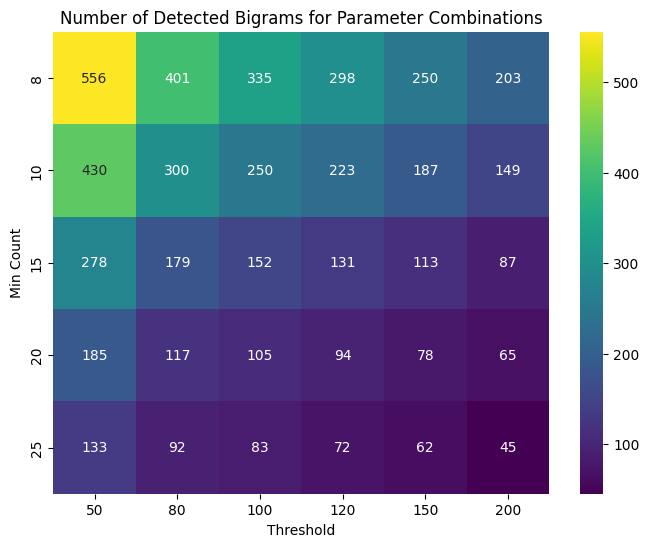

In [264]:
plot_heatmap(heatmap_data)

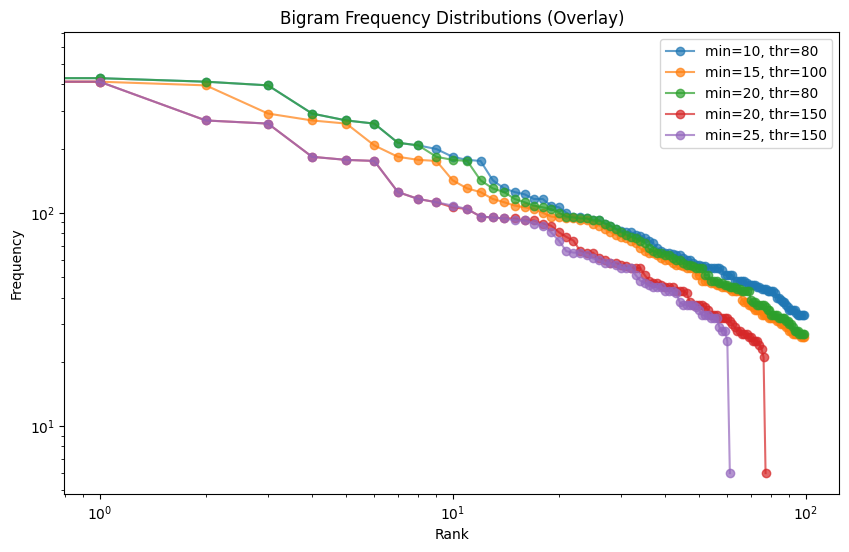

In [265]:
param_combos = [
    (10, 80),
    (15, 100),
    (20, 80),
    (20, 150),
    (25, 150),
]
plot_multiple_bigram_freqs(bigram_freqs_dict=bigram_freqs_dict, param_list=param_combos, top_n=100)

#### Train Bigram Model

In [266]:
def create_bigrams(tokens, phraser, string=False):
    """
    """

    bigrams = phraser[tokens]

    if string:
        return " ".join(bigrams)
    
    return bigrams

In [267]:
token_corpus = all_text_df["tokens"].tolist() # create nested list of corpus tokens

bigram_model = Phrases(token_corpus, min_count=10, threshold=80) # train bigram model 
bigram_phraser = Phraser(bigram_model) # optomize model

all_text_df["bigrams"] = all_text_df["tokens"].apply(create_bigrams, phraser=bigram_phraser) # apply to documents

#### Inspect Bigrams

In [268]:
# look at bigrams in a specific document

def extract_bigrams_from_doc(doc_tokens, phraser):
    bigrammed = phraser[doc_tokens]
    return [tok for tok in bigrammed if "_" in tok]

extract_bigrams_from_doc(all_text_df["tokens"].iloc[3], bigram_phraser)

['hurricane_katrina',
 'assembled_short',
 'robert_stafford',
 'hurricane_katrina',
 'whole_part',
 'calendar_quarter',
 'robert_stafford',
 'gao_study',
 'waste_fraud',
 'waste_fraud',
 'waste_fraud',
 'waste_fraud',
 'waste_fraud',
 'et_seq',
 'impacted_distressed',
 'hurricane_katrina',
 'major_disaster',
 'impacted_distressed',
 'indian_tribe',
 'robert_stafford',
 'indian_tribe',
 'indian_tribe',
 'robert_stafford',
 'hurricane_katrina',
 'et_seq',
 'census_tract',
 'census_tract',
 'census_tract',
 'set_forth',
 'waiting_list',
 'domestic_violence',
 'self_sufficiency',
 'et_seq',
 'demolition_disposition',
 'demolition_disposition',
 'convened_conducted',
 'demolition_disposition',
 'demolished_disposed',
 'contribution_toward',
 'demolition_disposition',
 'affirmatively_furthers',
 'contribution_toward',
 'demolition_disposition',
 'demolition_disposition',
 'hurricane_katrina',
 'major_disaster',
 'declared_president',
 'robert_stafford',
 'hurricane_katrina',
 'hurricane_katr

In [269]:
# look at bigrams across all documents - in dataframe

bigram_counter = Counter()

for doc in all_text_df["tokens"]:
    for tok in bigram_phraser[doc]:
        if "_" in tok:
            bigram_counter[tok] += 1

bigram_df = pd.DataFrame(
    bigram_counter.items(),
    columns=["bigram", "count"]
).sort_values("count", ascending=False)

bigram_df.head(20)

,bigram,count
28,et_seq,2154
0,assembled_short,1482
23,meaning_given,1072
47,indian_tribe,1065
24,authorization_appropriation,998
191,mckinney_vento,794
121,internal_revenue,684
33,real_estate,632
29,loss_mitigation,578
95,safety_soundness,573


### 3. Vectorize

In [270]:
# bag of words 

all_text_df["bigrams_str"] = all_text_df["bigrams"].apply(lambda x: " ".join(x)) # join for vectorizer

count_vectorizer = CountVectorizer(
    tokenizer=lambda x: x.split(), # split on space
    preprocessor=None, # no preprocessing
    lowercase=False # don't lowercase (already done)
)

bow_matrix = count_vectorizer.fit_transform(all_text_df["bigrams_str"])

bow_df = pd.DataFrame(bow_matrix.toarray(),
                      columns=count_vectorizer.get_feature_names_out())

bow_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,aa,aaa,aapi,ab,abandoned,abandoned_foreclosed,abandoned_railroad,abandoning,abandonment,abate,...,zero_carbon,zika,zip,zone,zoned,zoned_primarily,zoning,zoning_framework,zora,zz
0,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1653,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1655,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Save

In [271]:
bow_df.to_csv("../data/processed_text/bigrams_count_11_23.csv", index=False)

In [272]:
all_text_df.to_csv("../data/processed_text/text_df_11_23.csv", index=False)